# Applying Trained Traffic Sign Classifiers

---

This notebook is part of https://github.com/risc-mi/atsd.

This notebook demonstrates how pre-trained traffic sign classifiers, as presented in our accompanying paper, can be applied to traffic sign images from [ATSD-Signs](https://contentportal.asfinag.at/traffic-sign-catalogue) or other data sets.

## Package Imports

In [1]:
from pathlib import Path
import json
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models
from skimage import transform
from skimage.io import imread

## Paths

Set `ROOT` to the path to the directory where ATSD-Signs is located. This is the directory containing folders `"/train"` and `"/test"`.

In [2]:
ROOT = Path('path/to/atsd-signs')

## Network Architecture

We use the network architecture proposed by [Li and Wang](https://github.com/hellojialee/Traffic_Sign_Recognition_Efficient_CNNs/blob/master/Classification/Classifer_for_Traffic_sign.ipynb):

In [3]:
def conv_block(x, filters: int, kernel: tuple):
    x = layers.Conv2D(filters, kernel, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization(epsilon=1e-06, axis=3)(x)
    return layers.Activation('relu')(x)


def li_wang_network(input_shape: tuple = (48, 48, 3), n_classes: int = 60) -> models.Model:
    x = layers.Input(shape=input_shape)

    # first block
    x0 = conv_block(x, 32, (3, 3))
    x0 = conv_block(x0, 48, (7, 1))
    x0 = conv_block(x0, 48, (1, 7))
    x0 = layers.MaxPooling2D(pool_size=(2, 2))(x0)
    x0 = layers.Dropout(0.2)(x0)

    # second block (two parallel branches)
    x1 = conv_block(x0, 64, (3, 1))
    x1 = conv_block(x1, 64, (1, 3))

    x2 = conv_block(x0, 64, (1, 7))
    x2 = conv_block(x2, 64, (7, 1))

    y = layers.Concatenate(axis=-1)([x1, x2])
    y = layers.MaxPooling2D(pool_size=(2, 2))(y)
    y = layers.Dropout(0.2)(y)

    # third block
    y = conv_block(y, 128, (3, 3))
    y = conv_block(y, 256, (3, 3))
    y = layers.MaxPooling2D(pool_size=(2, 2))(y)
    y = layers.Dropout(0.3)(y)

    # fourth block
    y = layers.Flatten()(y)
    y = layers.Dense(256, kernel_initializer='he_normal')(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.Dropout(0.4)(y)

    # classification head
    y = layers.Dense(n_classes, activation='softmax', kernel_initializer='he_normal')(y)

    return models.Model(x, y)

Initialize the neural net:

In [4]:
model = li_wang_network()

Load trained weights; see `"/weights/classification/README.md"` for information about the different versions:

In [5]:
model_version = 'v7'

In [6]:
model.load_weights(f'weights/classification/{model_version}.h5')

Load pre-computed mean and standard deviation for scaling input images, and list of class IDs:

In [7]:
with open(f'weights/classification/{model_version}.json', mode='rt') as f:
    dct = json.load(f)
mean = np.array(dct['mean'])
std = np.array(dct['std'])
classes = dct['classes']
len(classes)

60

## Load and Pre-Process Images

In [8]:
def resize(img: np.ndarray, size) -> np.ndarray:
    factor = min(a / img.shape[i] for i, a in enumerate(size))
    img = transform.rescale(img, scale=tuple([factor] * len(size)), mode='constant', cval=0.0, order=1,
                            multichannel=True, anti_aliasing=True)
    out = np.zeros((*size, img.shape[-1]), dtype=np.float32)
    offset = tuple(np.math.floor((a - img.shape[i]) / 2) for i, a in enumerate(size))
    out[offset[0]:(img.shape[0] + offset[0]), offset[1]:(img.shape[1] + offset[1])] = img
    return out

In [9]:
def preprocess_image(img: np.ndarray) -> np.ndarray:
    # assumes that input pixel values are in [0, 255] range, and that `img` has shape `(height, width, 3)`
    img = img - mean
    img /= std
    return resize(img, (48, 48))

Load some image from the test set of ATSD-Signs and display it:

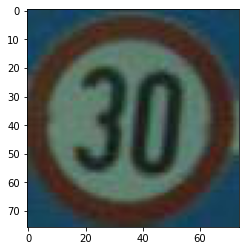

In [10]:
img = imread(ROOT / 'test/01_01/11875.jpg')
plt.imshow(img);

Pre-process the image, i.e., resize it to 48$\times$48 pixels and scaled pixel values:

In [11]:
img_pp = preprocess_image(img)
img_pp.shape

(48, 48, 3)

Apply the model and print the ID of the predicted class:

In [12]:
classes[np.argmax(model.predict(img_pp[np.newaxis]))]

'01_01'

## Evaluate Classifier on ATSD-Signs

In [13]:
def batch_iterate(root: Path, batch_size: int = 32):
    xs = []
    ys = []
    for file in root.glob('**/*.jpg'):
        xs.append(preprocess_image(imread(file)))
        ys.append(classes.index(file.parent.stem))
        if len(xs) == batch_size:
            yield np.stack(xs, axis=0), ys
            xs = []
            ys = []
    if xs:
        yield np.stack(xs, axis=0), ys

Iterate over data set and collect true labels and predictions:

In [14]:
y_true = []
y_hat = []
for x, y in batch_iterate(ROOT / 'test'):
    y_true += y
    y_hat += np.argmax(model.predict(x), axis=1).tolist()

Compute accuracy:

In [15]:
(np.array(y_true) == np.array(y_hat)).mean()

0.9777262180974478